# Import modules

In [11]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [12]:
class Hyperparams:
     def __init__(
        self,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [13]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [14]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: embeddings["<UNK>"] for key, _ in oov_embeddings.items()}

In [30]:
polyglot_embedding = {word: embed for word, embed in zip(embeddings.words, embeddings.vectors)}
pickle.dump(polyglot_embedding, open("../../datasets/features/polyglot_embedding.pkl", "ab"))

# Data Preprocessing

## Add OOV Flag

In [6]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [7]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [8]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [9]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [10]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5370 | MulticlassF1Score=0.0815
Batch-30 : CrossEntropyLoss=2.4841 | MulticlassF1Score=0.1532
Batch-45 : CrossEntropyLoss=2.4438 | MulticlassF1Score=0.2023
Batch-60 : CrossEntropyLoss=2.4044 | MulticlassF1Score=0.2618
Batch-75 : CrossEntropyLoss=2.3772 | MulticlassF1Score=0.3311
Batch-90 : CrossEntropyLoss=2.3561 | MulticlassF1Score=0.3826
Batch-105: CrossEntropyLoss=2.3555 | MulticlassF1Score=0.4210
Batch-120: CrossEntropyLoss=2.3661 | MulticlassF1Score=0.4489
Batch-135: CrossEntropyLoss=2.3702 | MulticlassF1Score=0.4711
Batch-150: CrossEntropyLoss=2.3468 | MulticlassF1Score=0.4889
Batch-165: CrossEntropyLoss=2.3507 | MulticlassF1Score=0.5041
Batch-180: CrossEntropyLoss=2.3433 | MulticlassF1Score=0.5152
Batch-195: CrossEntropyLoss=2.3405 | MulticlassF1Score=0.5277
Batch-210: CrossEntropyLoss=2.3378 | MulticlassF1Score=0.5385
Batch-225: CrossEntropyLoss=2.3323 | MulticlassF1Score=0.5482
Batch-226: CrossEntropyLoss=2.3315 | MulticlassF1Score=0.5488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3464 | MulticlassF1Score=0.7307
Batch-30 : CrossEntropyLoss=2.3465 | MulticlassF1Score=0.7278
Batch-45 : CrossEntropyLoss=2.3405 | MulticlassF1Score=0.7289
Batch-60 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7292
Batch-63 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.7290

Training   : Mean CrossEntropyLoss = 2.3969 | Mean MulticlassF1Score = 0.3753
Validation : Mean CrossEntropyLoss = 2.3342 | Mean MulticlassF1Score = 0.7289

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7391
Batch-30 : CrossEntropyLoss=2.3270 | MulticlassF1Score=0.7532
Batch-45 : CrossEntropyLoss=2.3246 | MulticlassF1Score=0.7542
Batch-60 : CrossEntropyLoss=2.3312 | MulticlassF1Score=0.7571
Batch-75 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7594
Batch-90 : CrossEntropyLoss=2.3256 | MulticlassF1Score=0.7604
Batch-105: CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7612
Batch-120: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7621
Batch-135: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7632
Batch-150: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7634
Batch-165: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7632
Batch-180: CrossEntropyLoss=2.3281 | MulticlassF1Score=0.7639
Batch-195: CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7649
Batch-210: CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7653
Batch-225: CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7650
Batch-226: CrossEntropyLoss=2.3352 | MulticlassF1Score=0.7649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3277 | MulticlassF1Score=0.7660
Batch-30 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7713
Batch-45 : CrossEntropyLoss=2.3264 | MulticlassF1Score=0.7696
Batch-60 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7699
Batch-63 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7702

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3214 | Mean MulticlassF1Score = 0.7586
Validation : Mean CrossEntropyLoss = 2.3196 | Mean MulticlassF1Score = 0.7696

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7681
Batch-30 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7702
Batch-45 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7717
Batch-60 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7705
Batch-75 : CrossEntropyLoss=2.3252 | MulticlassF1Score=0.7700
Batch-90 : CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7714
Batch-105: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7713
Batch-120: CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7720
Batch-135: CrossEntropyLoss=2.3240 | MulticlassF1Score=0.7724
Batch-150: CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7725
Batch-165: CrossEntropyLoss=2.3275 | MulticlassF1Score=0.7718
Batch-180: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7724
Batch-195: CrossEntropyLoss=2.3228 | MulticlassF1Score=0.7726
Batch-210: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7729
Batch-225: CrossEntropyLoss=2.3233 | MulticlassF1Score=0.7737
Batch-226: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7737

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7794
Batch-30 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7820
Batch-45 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7807
Batch-60 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7797
Batch-63 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7797

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3179 | Mean MulticlassF1Score = 0.7713
Validation : Mean CrossEntropyLoss = 2.3164 | Mean MulticlassF1Score = 0.7802

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3254 | MulticlassF1Score=0.7858
Batch-30 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.7861
Batch-45 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7854
Batch-60 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7818
Batch-75 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7809
Batch-90 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7812
Batch-105: CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7817
Batch-120: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7831
Batch-135: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7858
Batch-150: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7873
Batch-165: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7882
Batch-180: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7898
Batch-195: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7910
Batch-210: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7919
Batch-225: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.7930
Batch-226: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7930

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7990
Batch-30 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7981
Batch-45 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.8006
Batch-60 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.8001
Batch-63 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8003

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3119 | Mean MulticlassF1Score = 0.7859
Validation : Mean CrossEntropyLoss = 2.3101 | Mean MulticlassF1Score = 0.7995

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8066
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8090
Batch-45 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.8077
Batch-60 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8063
Batch-75 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8058
Batch-90 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8043
Batch-105: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8045
Batch-120: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8058
Batch-135: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8070
Batch-150: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8083
Batch-165: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8087
Batch-180: CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8091
Batch-195: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8096
Batch-210: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8106
Batch-225: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8105
Batch-226: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8106

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8149
Batch-30 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8167
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8142
Batch-60 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8139
Batch-63 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3064 | Mean MulticlassF1Score = 0.8069
Validation : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8146

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8203
Batch-30 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8180
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8194
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8197
Batch-75 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8195
Batch-90 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8189
Batch-105: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8191
Batch-120: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8198
Batch-135: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8196
Batch-150: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8189
Batch-165: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8187
Batch-180: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8187
Batch-195: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.8184
Batch-210: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8185
Batch-225: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8181
Batch-226: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8181

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3209 | MulticlassF1Score=0.8142
Batch-30 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8124
Batch-45 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8145
Batch-60 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8155
Batch-63 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8156

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8193
Validation : Mean CrossEntropyLoss = 2.3051 | Mean MulticlassF1Score = 0.8159

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8171
Batch-30 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8177
Batch-45 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8233
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8247
Batch-75 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8263
Batch-90 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8272
Batch-105: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8295
Batch-120: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8306
Batch-135: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8307
Batch-150: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8310
Batch-165: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8314
Batch-180: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8319
Batch-195: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8320
Batch-210: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8325
Batch-225: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8326
Batch-226: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8325

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8310
Batch-30 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8323
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8321
Batch-63 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8321

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8273
Validation : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8318

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8421
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8355
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8349
Batch-60 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8362
Batch-75 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8366
Batch-90 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8370
Batch-105: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8381
Batch-120: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8377
Batch-135: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8377
Batch-150: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8383
Batch-165: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8389
Batch-180: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8386
Batch-195: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8387
Batch-210: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.8383
Batch-225: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8382
Batch-226: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8382

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8324
Batch-30 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8375
Batch-45 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8351
Batch-60 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8345
Batch-63 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8347

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8374
Validation : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8337

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8352
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8384
Batch-45 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8398
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8391
Batch-75 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8395
Batch-90 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8401
Batch-105: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8399
Batch-120: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8404
Batch-135: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8400
Batch-150: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8400
Batch-165: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8402
Batch-180: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8402
Batch-195: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8402
Batch-210: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8403
Batch-225: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8402
Batch-226: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8336
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8341
Batch-60 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8358
Batch-63 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2970 | Mean MulticlassF1Score = 0.8398
Validation : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8360

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8486
Batch-30 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8461
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8457
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8451
Batch-75 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8442
Batch-90 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8437
Batch-105: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8444
Batch-120: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8457
Batch-135: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8482
Batch-150: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8496
Batch-165: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8511
Batch-180: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8526
Batch-195: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8536
Batch-210: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8545
Batch-225: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8552
Batch-226: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8553

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8655
Batch-30 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8641
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8637
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8642
Batch-63 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8637

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8481
Validation : Mean CrossEntropyLoss = 2.2904 | Mean MulticlassF1Score = 0.8660

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8724
Batch-30 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8709
Batch-45 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8695
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8708
Batch-75 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8720
Batch-90 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8715
Batch-105: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8711
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8703
Batch-135: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8701
Batch-150: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8705
Batch-165: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8703
Batch-180: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8703
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8709
Batch-210: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8715
Batch-225: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8716
Batch-226: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8624
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8656
Batch-45 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8647
Batch-60 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8646
Batch-63 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8652

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2876 | Mean MulticlassF1Score = 0.8709
Validation : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8636

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8792
Batch-30 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8752
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8751
Batch-60 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8741
Batch-75 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8738
Batch-90 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8733
Batch-105: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8721
Batch-120: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8727
Batch-135: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8732
Batch-150: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8728
Batch-165: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8729
Batch-180: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8736
Batch-195: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8734
Batch-210: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8740
Batch-225: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8740
Batch-226: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8741

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8680
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8667
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8656
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8665
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8666

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2866 | Mean MulticlassF1Score = 0.8741
Validation : Mean CrossEntropyLoss = 2.2893 | Mean MulticlassF1Score = 0.8658

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8807
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8758
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8769
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8760
Batch-75 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8756
Batch-90 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8766
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8769
Batch-120: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8762
Batch-135: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8763
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8763
Batch-165: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8767
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8766
Batch-195: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8766
Batch-210: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8765
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8762
Batch-226: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8762

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8681
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8695
Batch-45 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8672
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8677
Batch-63 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8676

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2859 | Mean MulticlassF1Score = 0.8770
Validation : Mean CrossEntropyLoss = 2.2890 | Mean MulticlassF1Score = 0.8682

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8734
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8783
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8786
Batch-75 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8781
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8788
Batch-105: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8780
Batch-120: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8778
Batch-135: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8780
Batch-150: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8783
Batch-165: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8783
Batch-180: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8785
Batch-195: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8785
Batch-210: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8786
Batch-225: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8788
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8787

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8692
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8702
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8711
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8718
Batch-63 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8724

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8776
Validation : Mean CrossEntropyLoss = 2.2875 | Mean MulticlassF1Score = 0.8707

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8860
Batch-30 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8872
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8864
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8891
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8913
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8935
Batch-120: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8949
Batch-135: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8966
Batch-150: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8976
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8987
Batch-180: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8991
Batch-195: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9000
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9002
Batch-225: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9008
Batch-226: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9009

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9019
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8995
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8996
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9001
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8999

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.8931
Validation : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.9002

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9078
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9101
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9114
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9119
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9112
Batch-105: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9117
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9121
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9122
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9123
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9121
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9123
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9121
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9125
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9125
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9125

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8995
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9003
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9014
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9012

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9115
Validation : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.9006

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9148
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9137
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9139
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9139
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9143
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9142
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9137
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9137
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9140
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9141
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9141
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9140
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9140
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9142
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9019
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9016
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9013
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9018
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9018

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9142
Validation : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9021

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9116
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9142
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9157
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9163
Batch-75 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9166
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9163
Batch-105: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9171
Batch-120: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9168
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9162
Batch-150: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9160
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9156
Batch-180: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9157
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9155
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9156
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9157
Batch-226: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9156

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9058
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9003
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9001
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9012
Batch-63 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9013

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9154
Validation : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9021

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9142
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9161
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9160
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9170
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9177
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9176
Batch-120: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9178
Batch-135: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9174
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9172
Batch-165: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9170
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9170
Batch-195: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9173
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9171
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9170
Batch-226: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9170

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9004
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9030
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9027
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9024

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9168
Validation : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9024

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9209
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9169
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9184
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9188
Batch-90 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9189
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9192
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9193
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9190
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9189
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9188
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9185
Batch-195: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9182
Batch-210: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9178
Batch-225: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9180
Batch-226: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9180

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9048
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9036
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9039
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.9035

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9185
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9046

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9194
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9200
Batch-75 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9198
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9198
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9195
Batch-120: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9198
Batch-135: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9196
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9192
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9187
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9189
Batch-195: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9189
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9189
Batch-225: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9188
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9003
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9006
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9019
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9025
Batch-63 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9026

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9197
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9004

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9182
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9193
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9193
Batch-75 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9190
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9188
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9190
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9192
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9196
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9197
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9193
Batch-180: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9197
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9193
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9194
Batch-225: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9195
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9195

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9004
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9031
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9017
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9023
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9027

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9192
Validation : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9013

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9212
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9208
Batch-90 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9203
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9197
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9199
Batch-135: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9197
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9199
Batch-180: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9204
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9201
Batch-210: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9203
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9201
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9202

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9047
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9022
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9024
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9024

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9206
Validation : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9039

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9208
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9201
Batch-90 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9200
Batch-105: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9196
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9203
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9197
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9200
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9200
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9203
Batch-195: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9203
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9203
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9204
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9204

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9063
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9025
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9029
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9027
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9030

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9207
Validation : Mean CrossEntropyLoss = 2.2779 | Mean MulticlassF1Score = 0.9034

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9213
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9206
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9201
Batch-90 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9192
Batch-105: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9200
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9199
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9199
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9204
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9207
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9210
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9208
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9206
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9209
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9209

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9046
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9043
Batch-60 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.9029
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9031

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9201
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9036

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9253
Batch-75 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9230
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9223
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9225
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9224
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9221
Batch-150: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9212
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9214
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9218
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9216
Batch-210: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9215
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9213
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9213

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9007
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9013
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9004
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9018
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9022

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9229
Validation : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9002

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9187
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9211
Batch-75 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9203
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9202
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9204
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9206
Batch-135: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9206
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9208
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9210
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9212
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9214
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9217
Batch-225: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9215
Batch-226: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9215

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9012
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.9015
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9031
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9023
Batch-63 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9026

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9207
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9022

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9221
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9223
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9224
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9221
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9216
Batch-135: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9218
Batch-150: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9214
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9212
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9215
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9217
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9218
Batch-225: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9217
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9218

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9034
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9048
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9035
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9035

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9217
Validation : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9025

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9209
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9211
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9215
Batch-105: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9210
Batch-120: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9217
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9219
Batch-150: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9220
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9224
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9227
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9227
Batch-210: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9231
Batch-225: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9232
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9232

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9058
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9058
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9079
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9060
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9066

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9218
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9061

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9247
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9258
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9263
Batch-105: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9261
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9260
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9261
Batch-150: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9260
Batch-165: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9257
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9261
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9258
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9259
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9261
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9260

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9065
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9073
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9072
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9075
Batch-63 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.9073

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9253
Validation : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9058

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9285
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9280
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9275
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9270
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9271
Batch-135: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9272
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9273
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9271
Batch-180: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9268
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9269
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9269
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9270
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9075
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9063
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9068
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9070
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9274
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9070

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9294
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9289
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9290
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9289
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9281
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9279
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9275
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9278
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9275
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9279
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9279
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9280
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9276
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9275

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9111
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9069
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9080
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9083

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9283
Validation : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9097

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9263
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9267
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9272
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9279
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9280
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9283
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9297
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9312
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9323
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9332
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9337
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9338

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9286
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9261

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9466
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9466
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9288
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9282

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9480
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9481
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9477
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9487
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9490
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9490

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9338
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9352
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9351
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9349

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9485
Validation : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9355

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9535
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9547
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9549
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9558
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9555
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9553
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9556
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9554
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9552
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9552
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9552
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9549
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9552
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9551
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9552
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9552

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9375
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2615 | Mean MulticlassF1Score = 0.9552
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9381

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9559
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9563
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9562
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9573
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9578
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9585
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9580
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9580
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9578
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9577
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9583
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9388
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9388
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9392

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9575
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9388

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9621
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9624
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9616
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9613
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9611
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9604
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9610
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9607
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9608
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9388
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9398
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9402

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9616
Validation : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9399

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9608
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9609
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9620
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9622
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9627
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9630
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9630
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9631
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9629
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9631
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9629
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9629

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9414
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9414
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9409

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9403

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9654
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9641
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9638
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9642
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9405
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9406

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9403

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9639
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9658
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9656
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9653
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9398
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9400

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9406

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9650
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9644
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9648
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9655
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9398
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9404

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9388

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9406
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9407

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9399

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9669
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9406
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9406

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9402

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9655
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9664
Batch-105: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9398
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9400

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9402

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9408
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9406

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9395

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9408
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9407

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9412

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9406
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9416
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9410

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9407

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9407
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9401
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9401

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9409
Patience = 1/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9400
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9401

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9413
Patience = 2/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2574
Best CrossEntropyLoss training    : 2.2659
Best MulticlassF1Score validation : 0.9676
Best MulticlassF1Score validation : 0.9407
Training duration                 : 1.9830 minutes.
Training date                     : 2022-10-24 18:51:11.326798+08:00


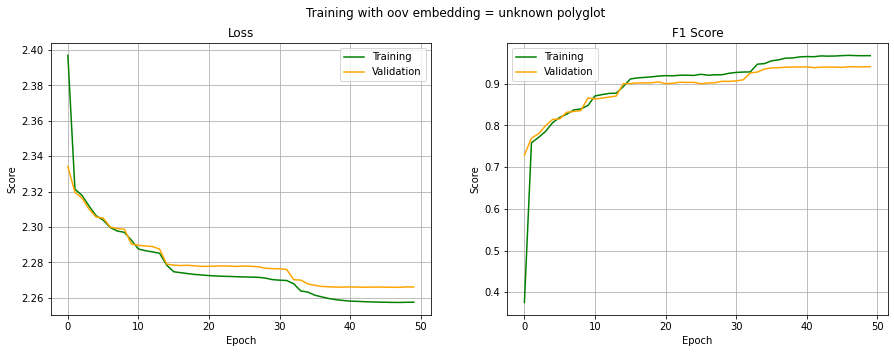

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/unk/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = unknown polyglot")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9680, device='cuda:0'),
 tensor(0.9401, device='cuda:0'),
 tensor(0.9376, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9680, device='cuda:0'),
 tensor(0.9401, device='cuda:0'),
 tensor(0.9376, device='cuda:0'))

## Heatmap

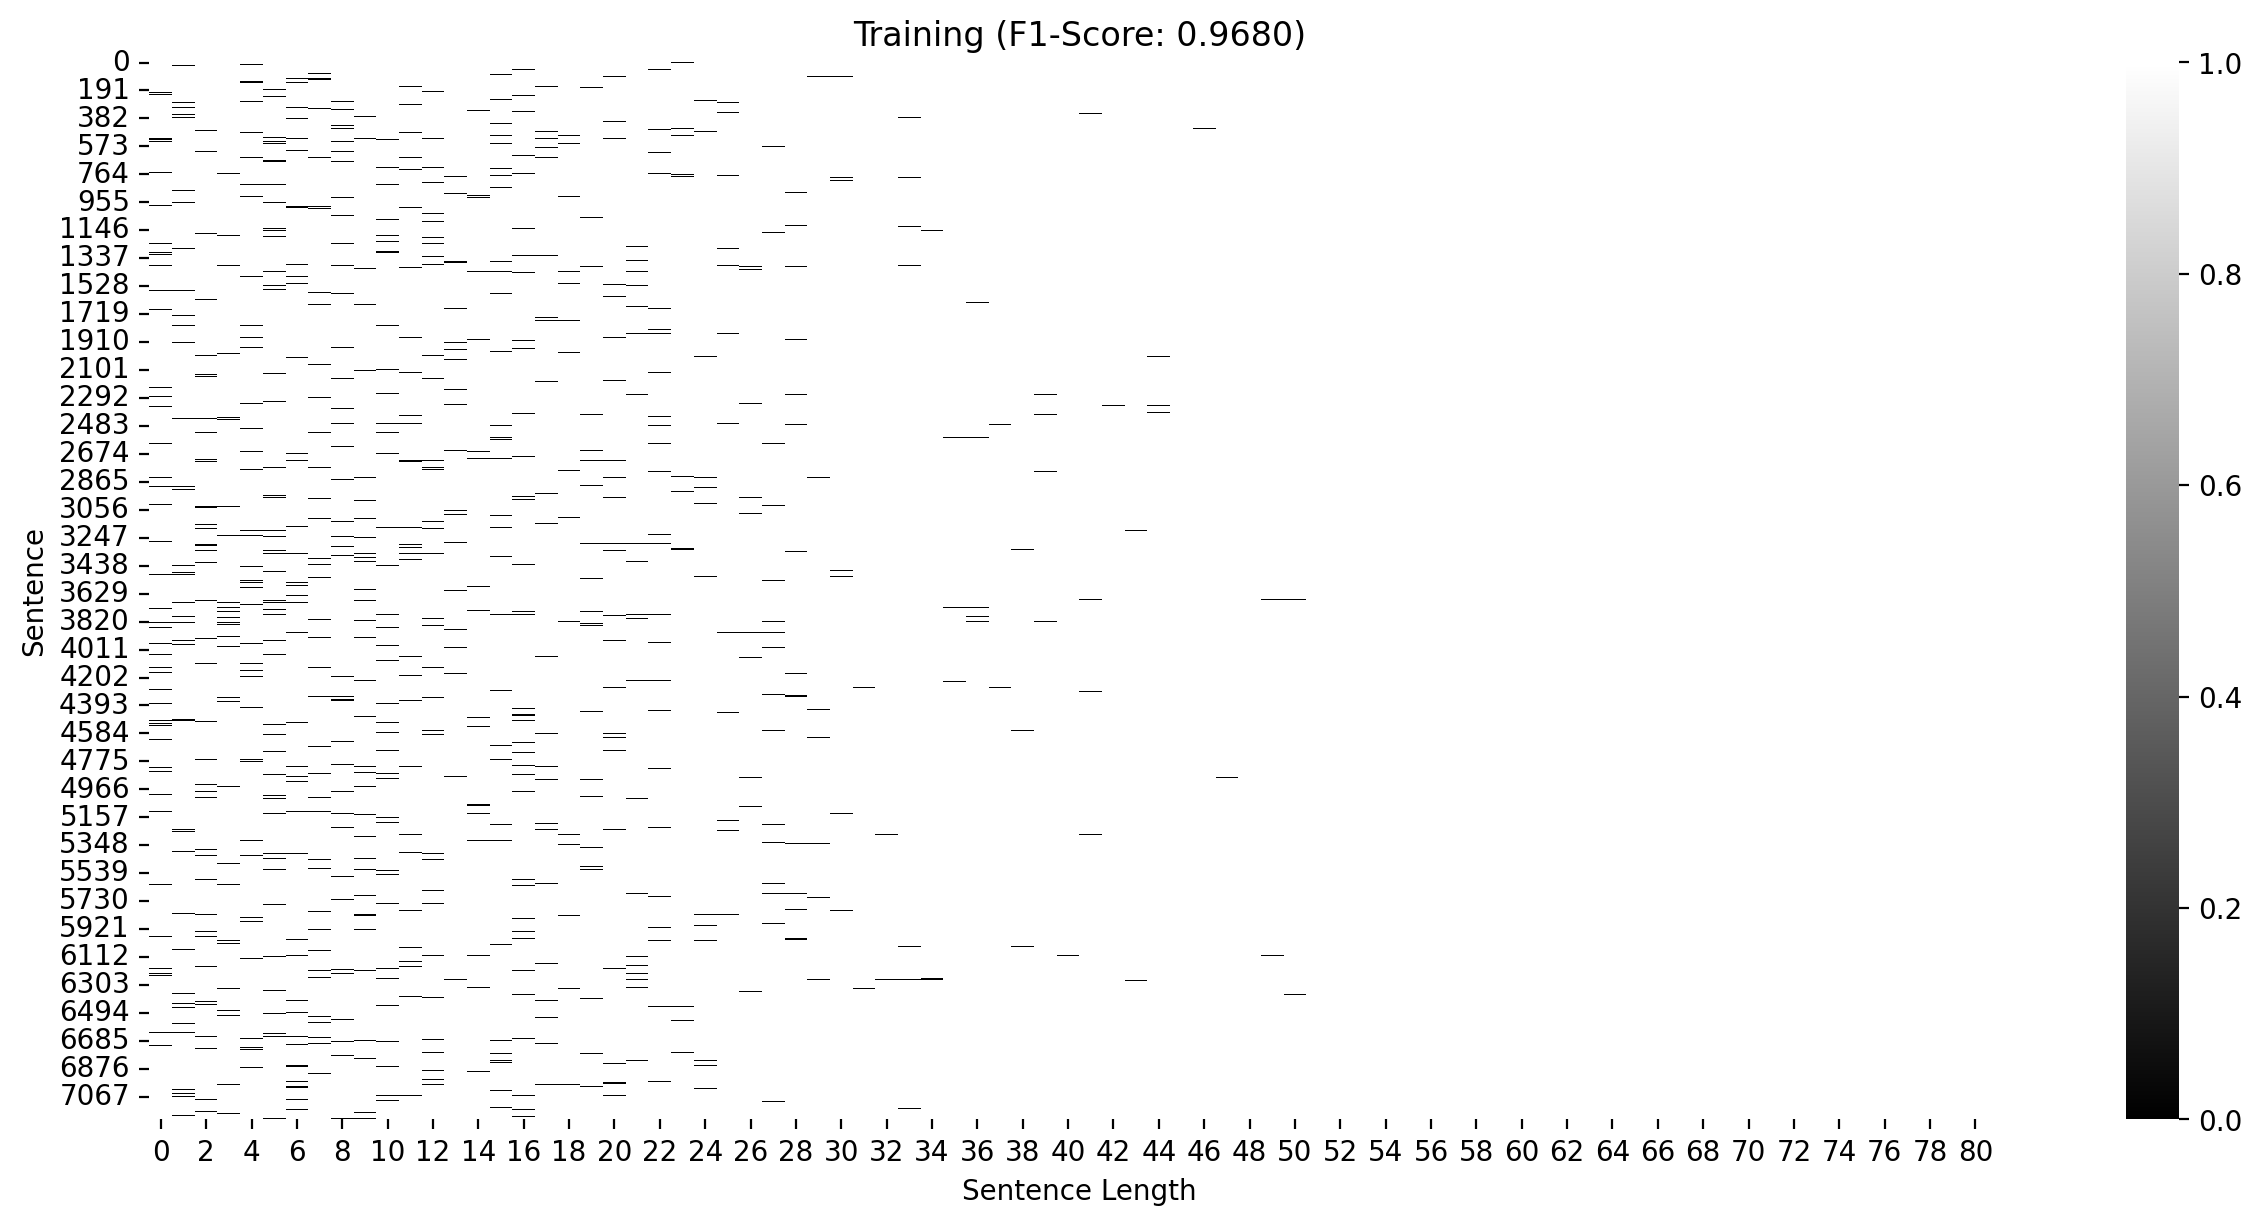

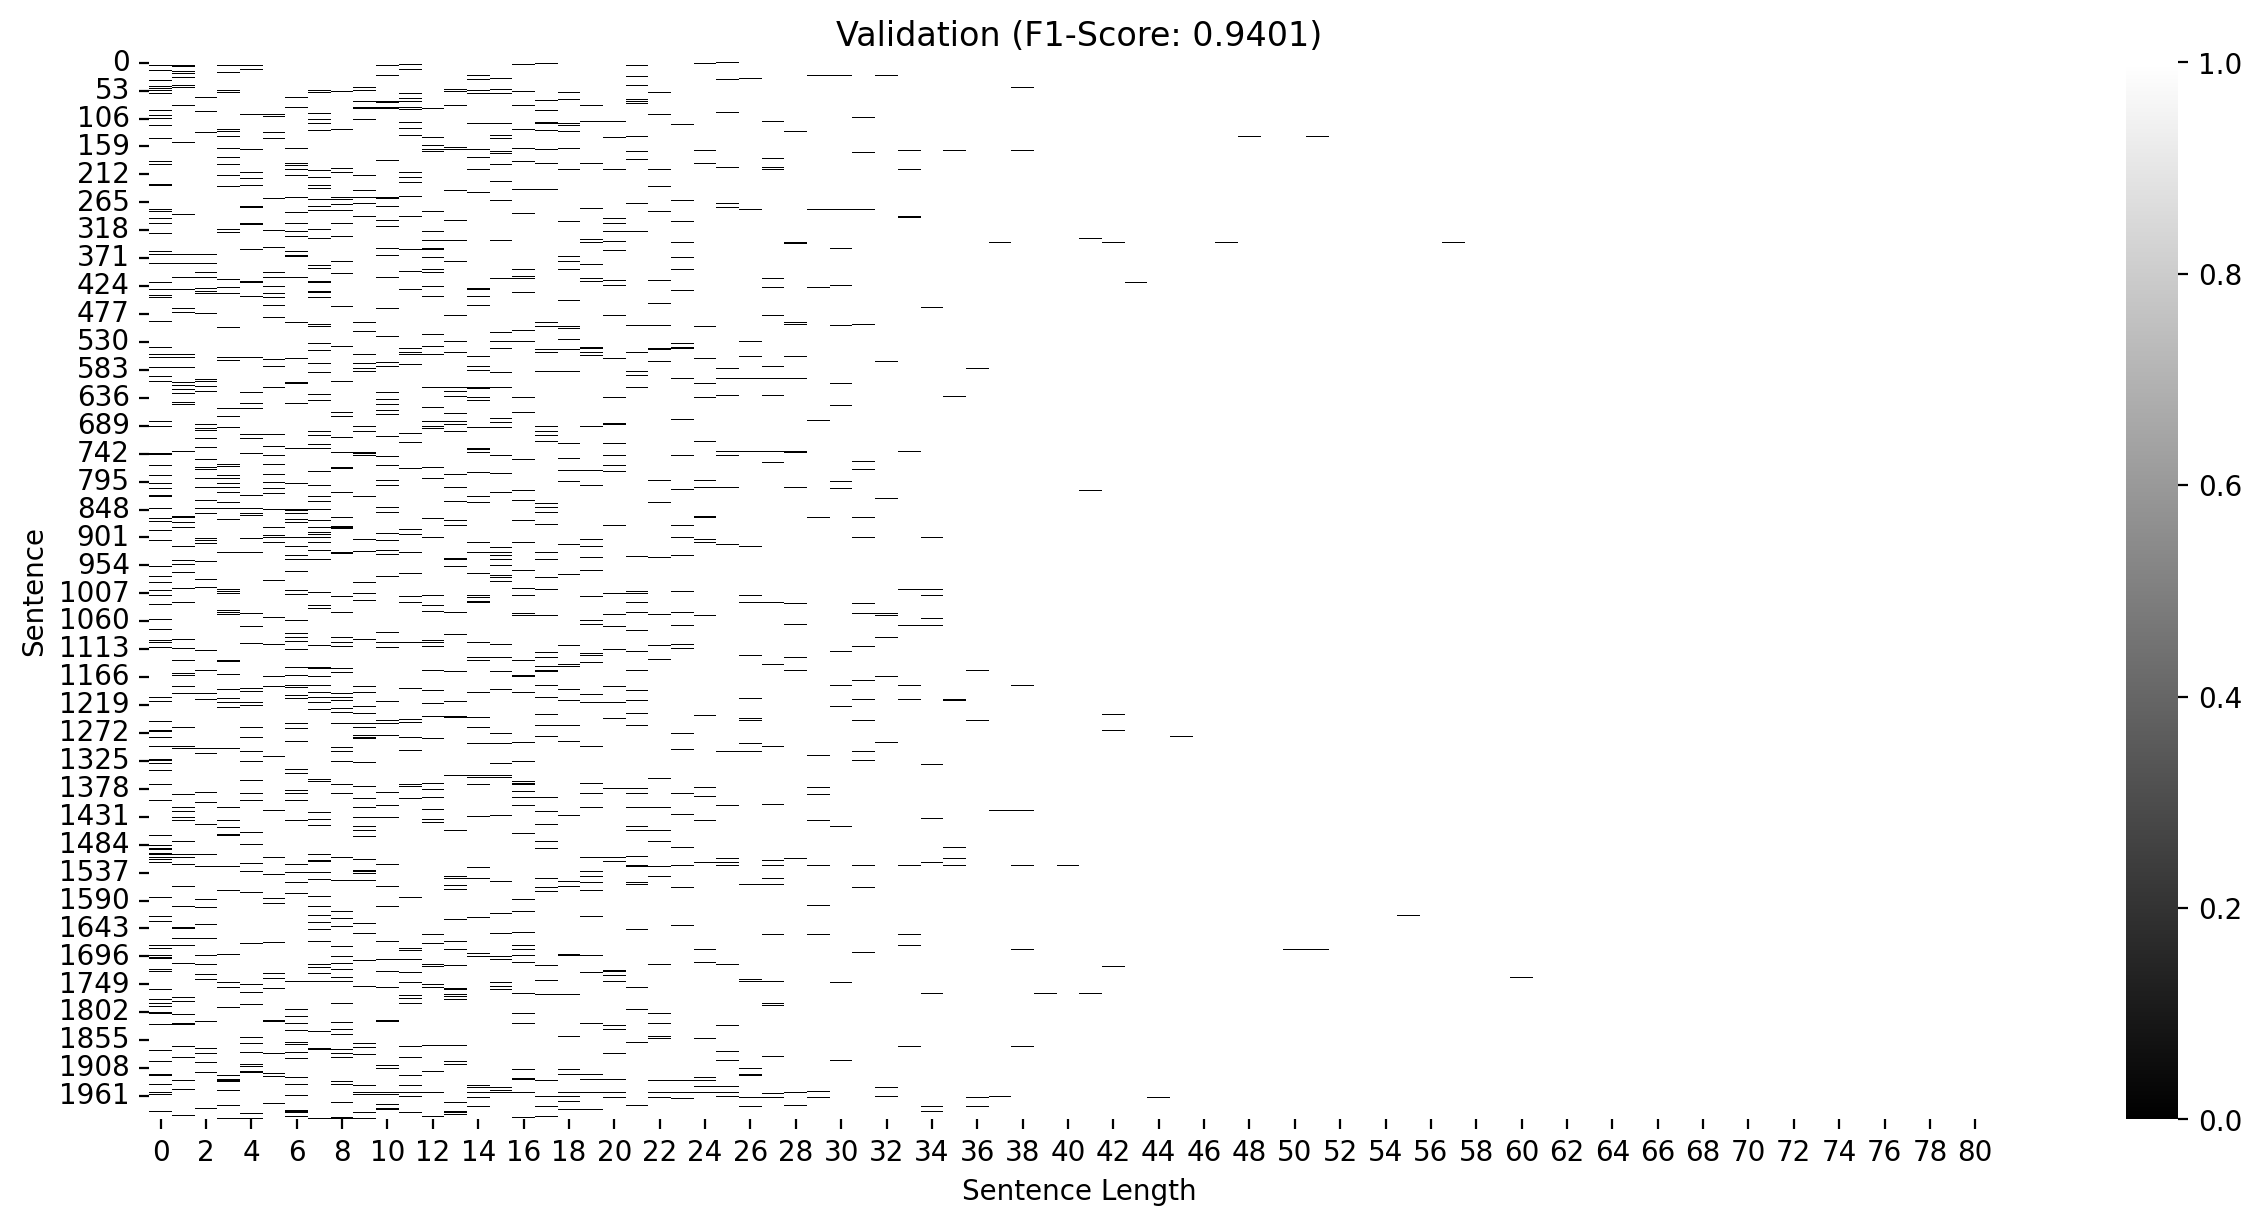

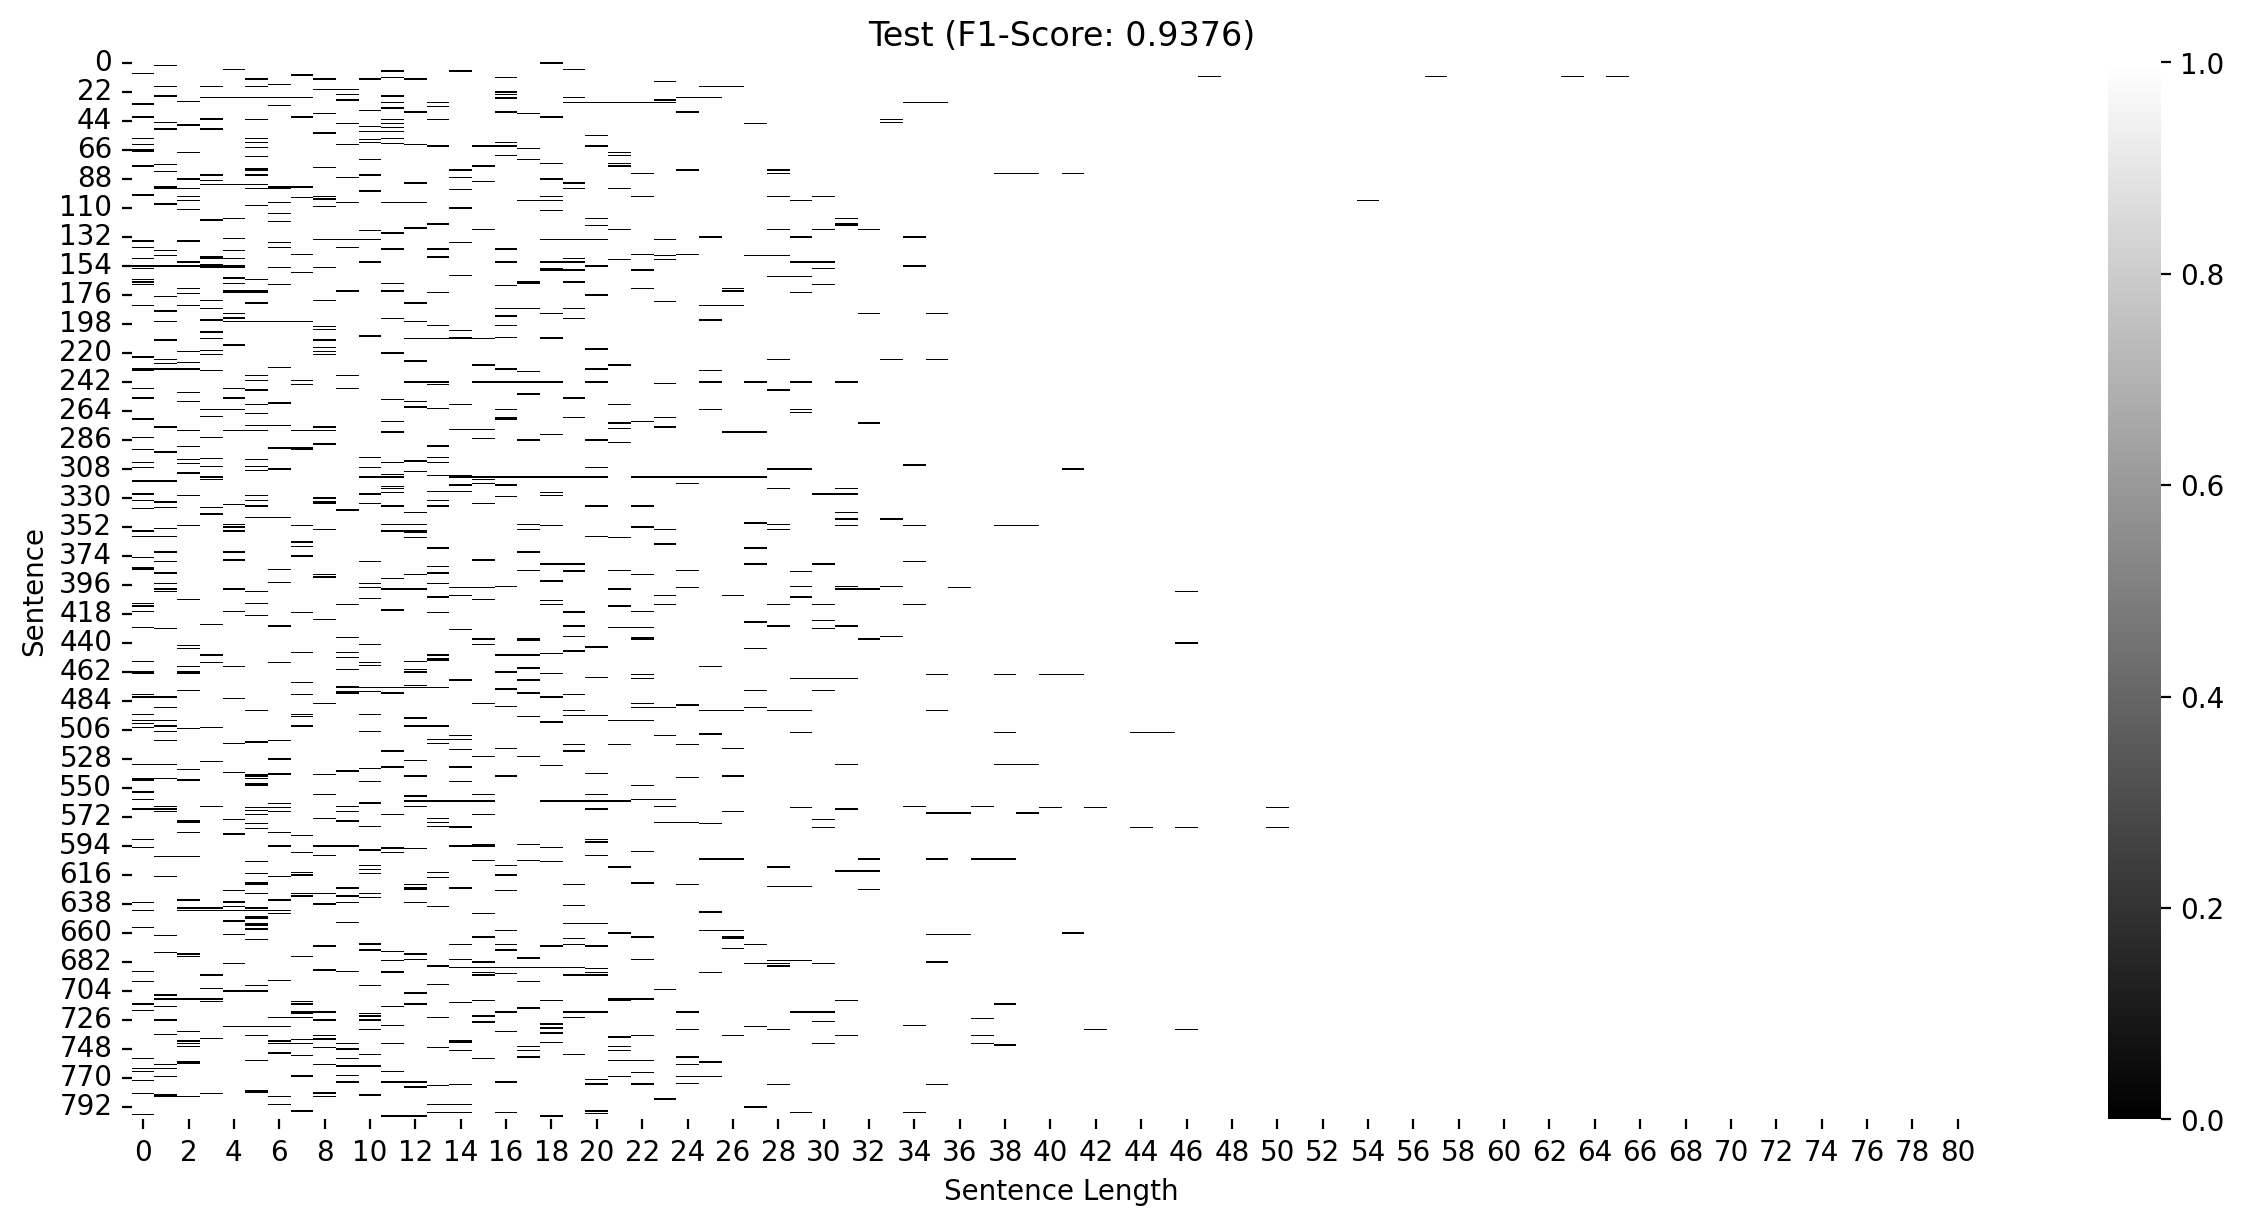

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


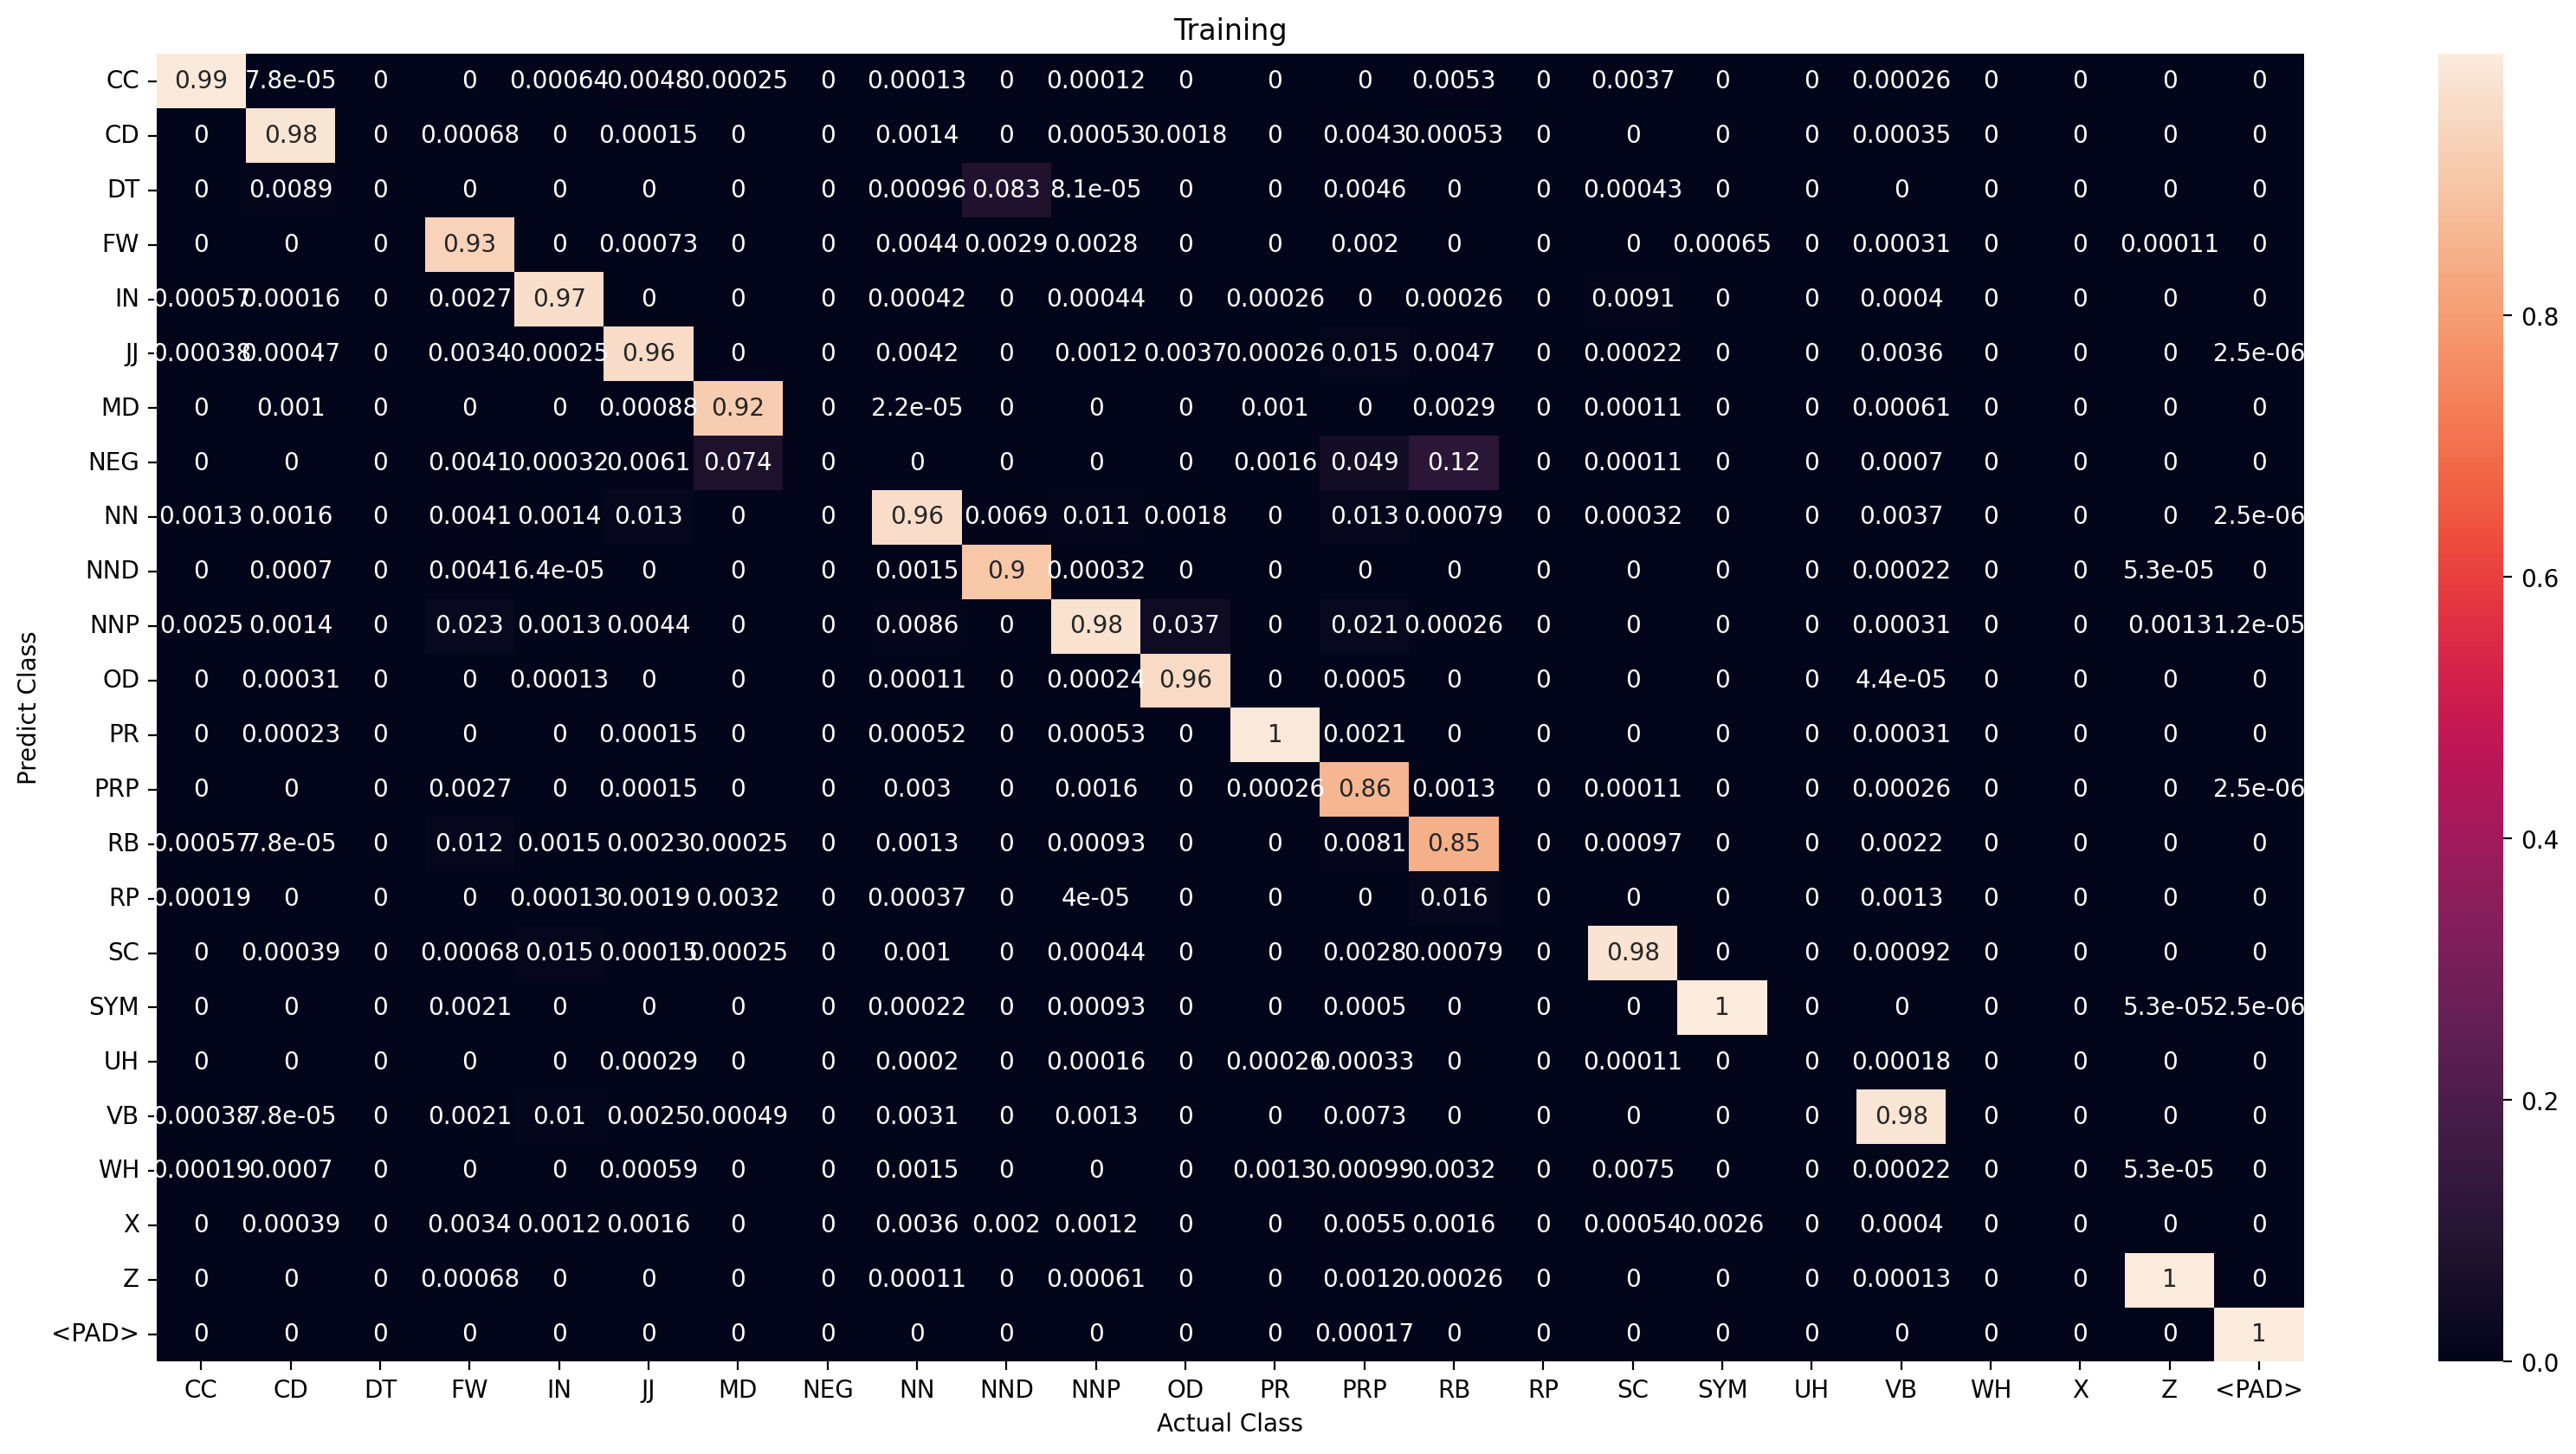

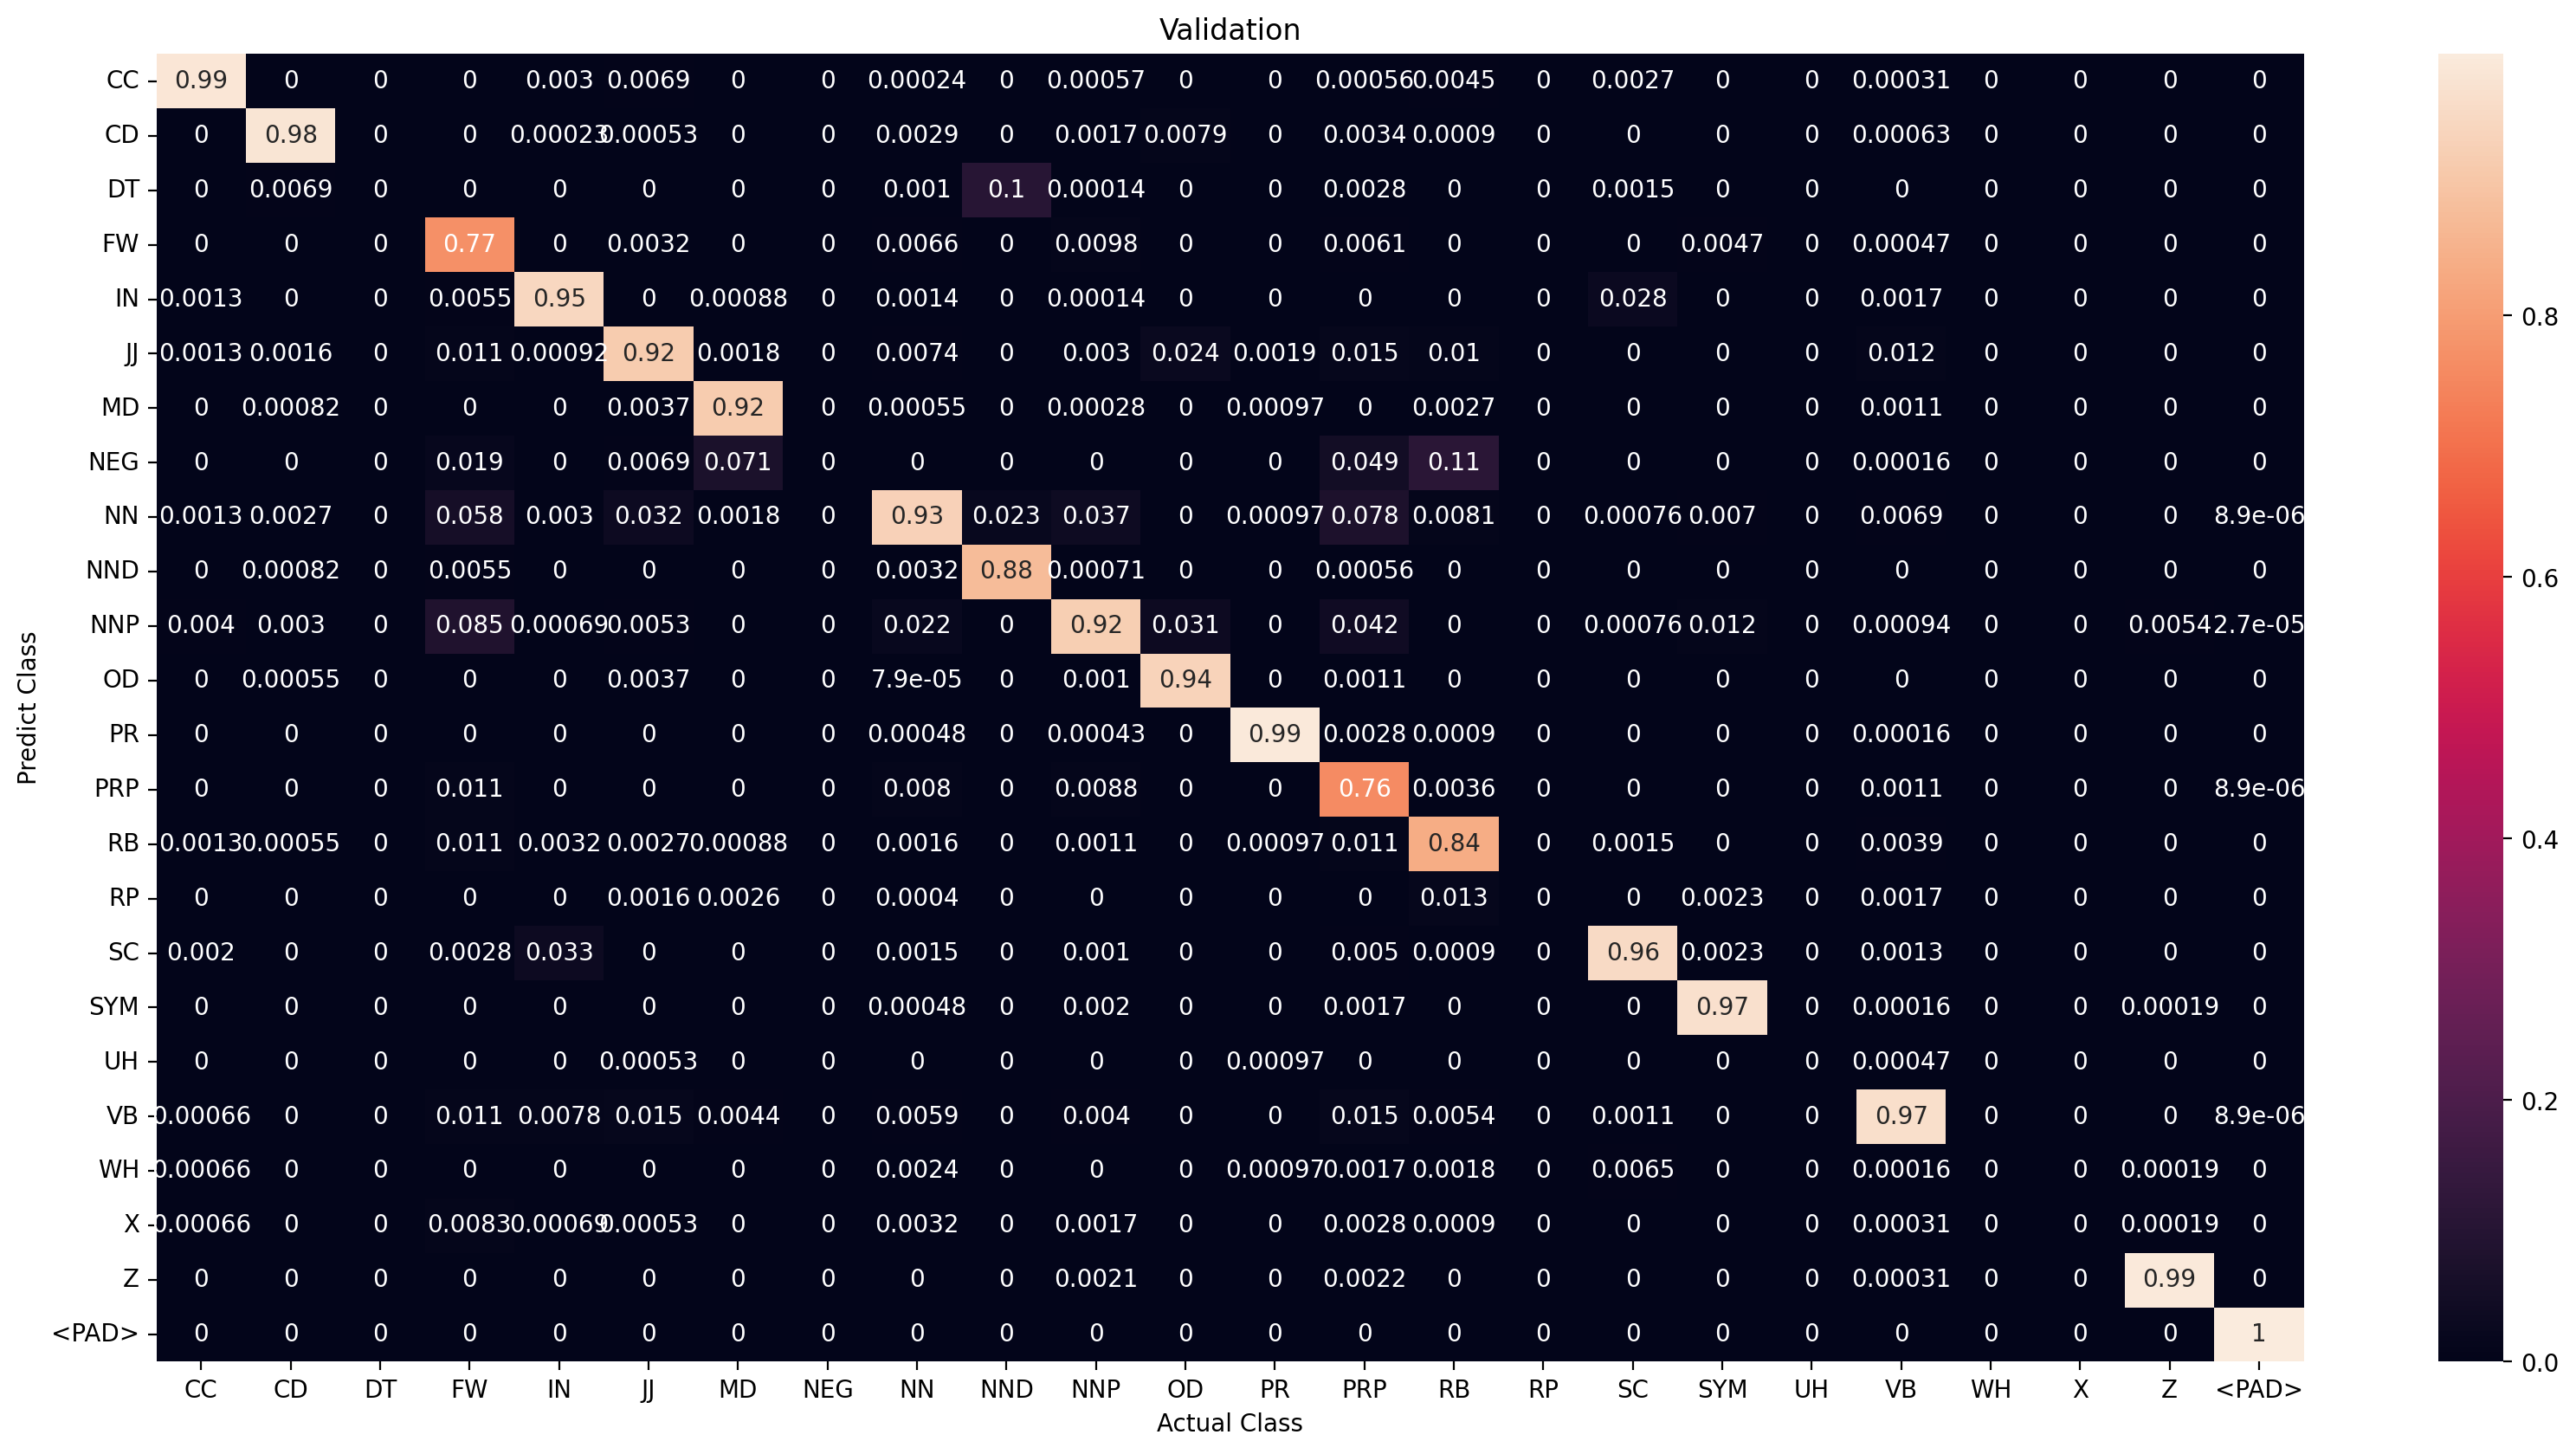

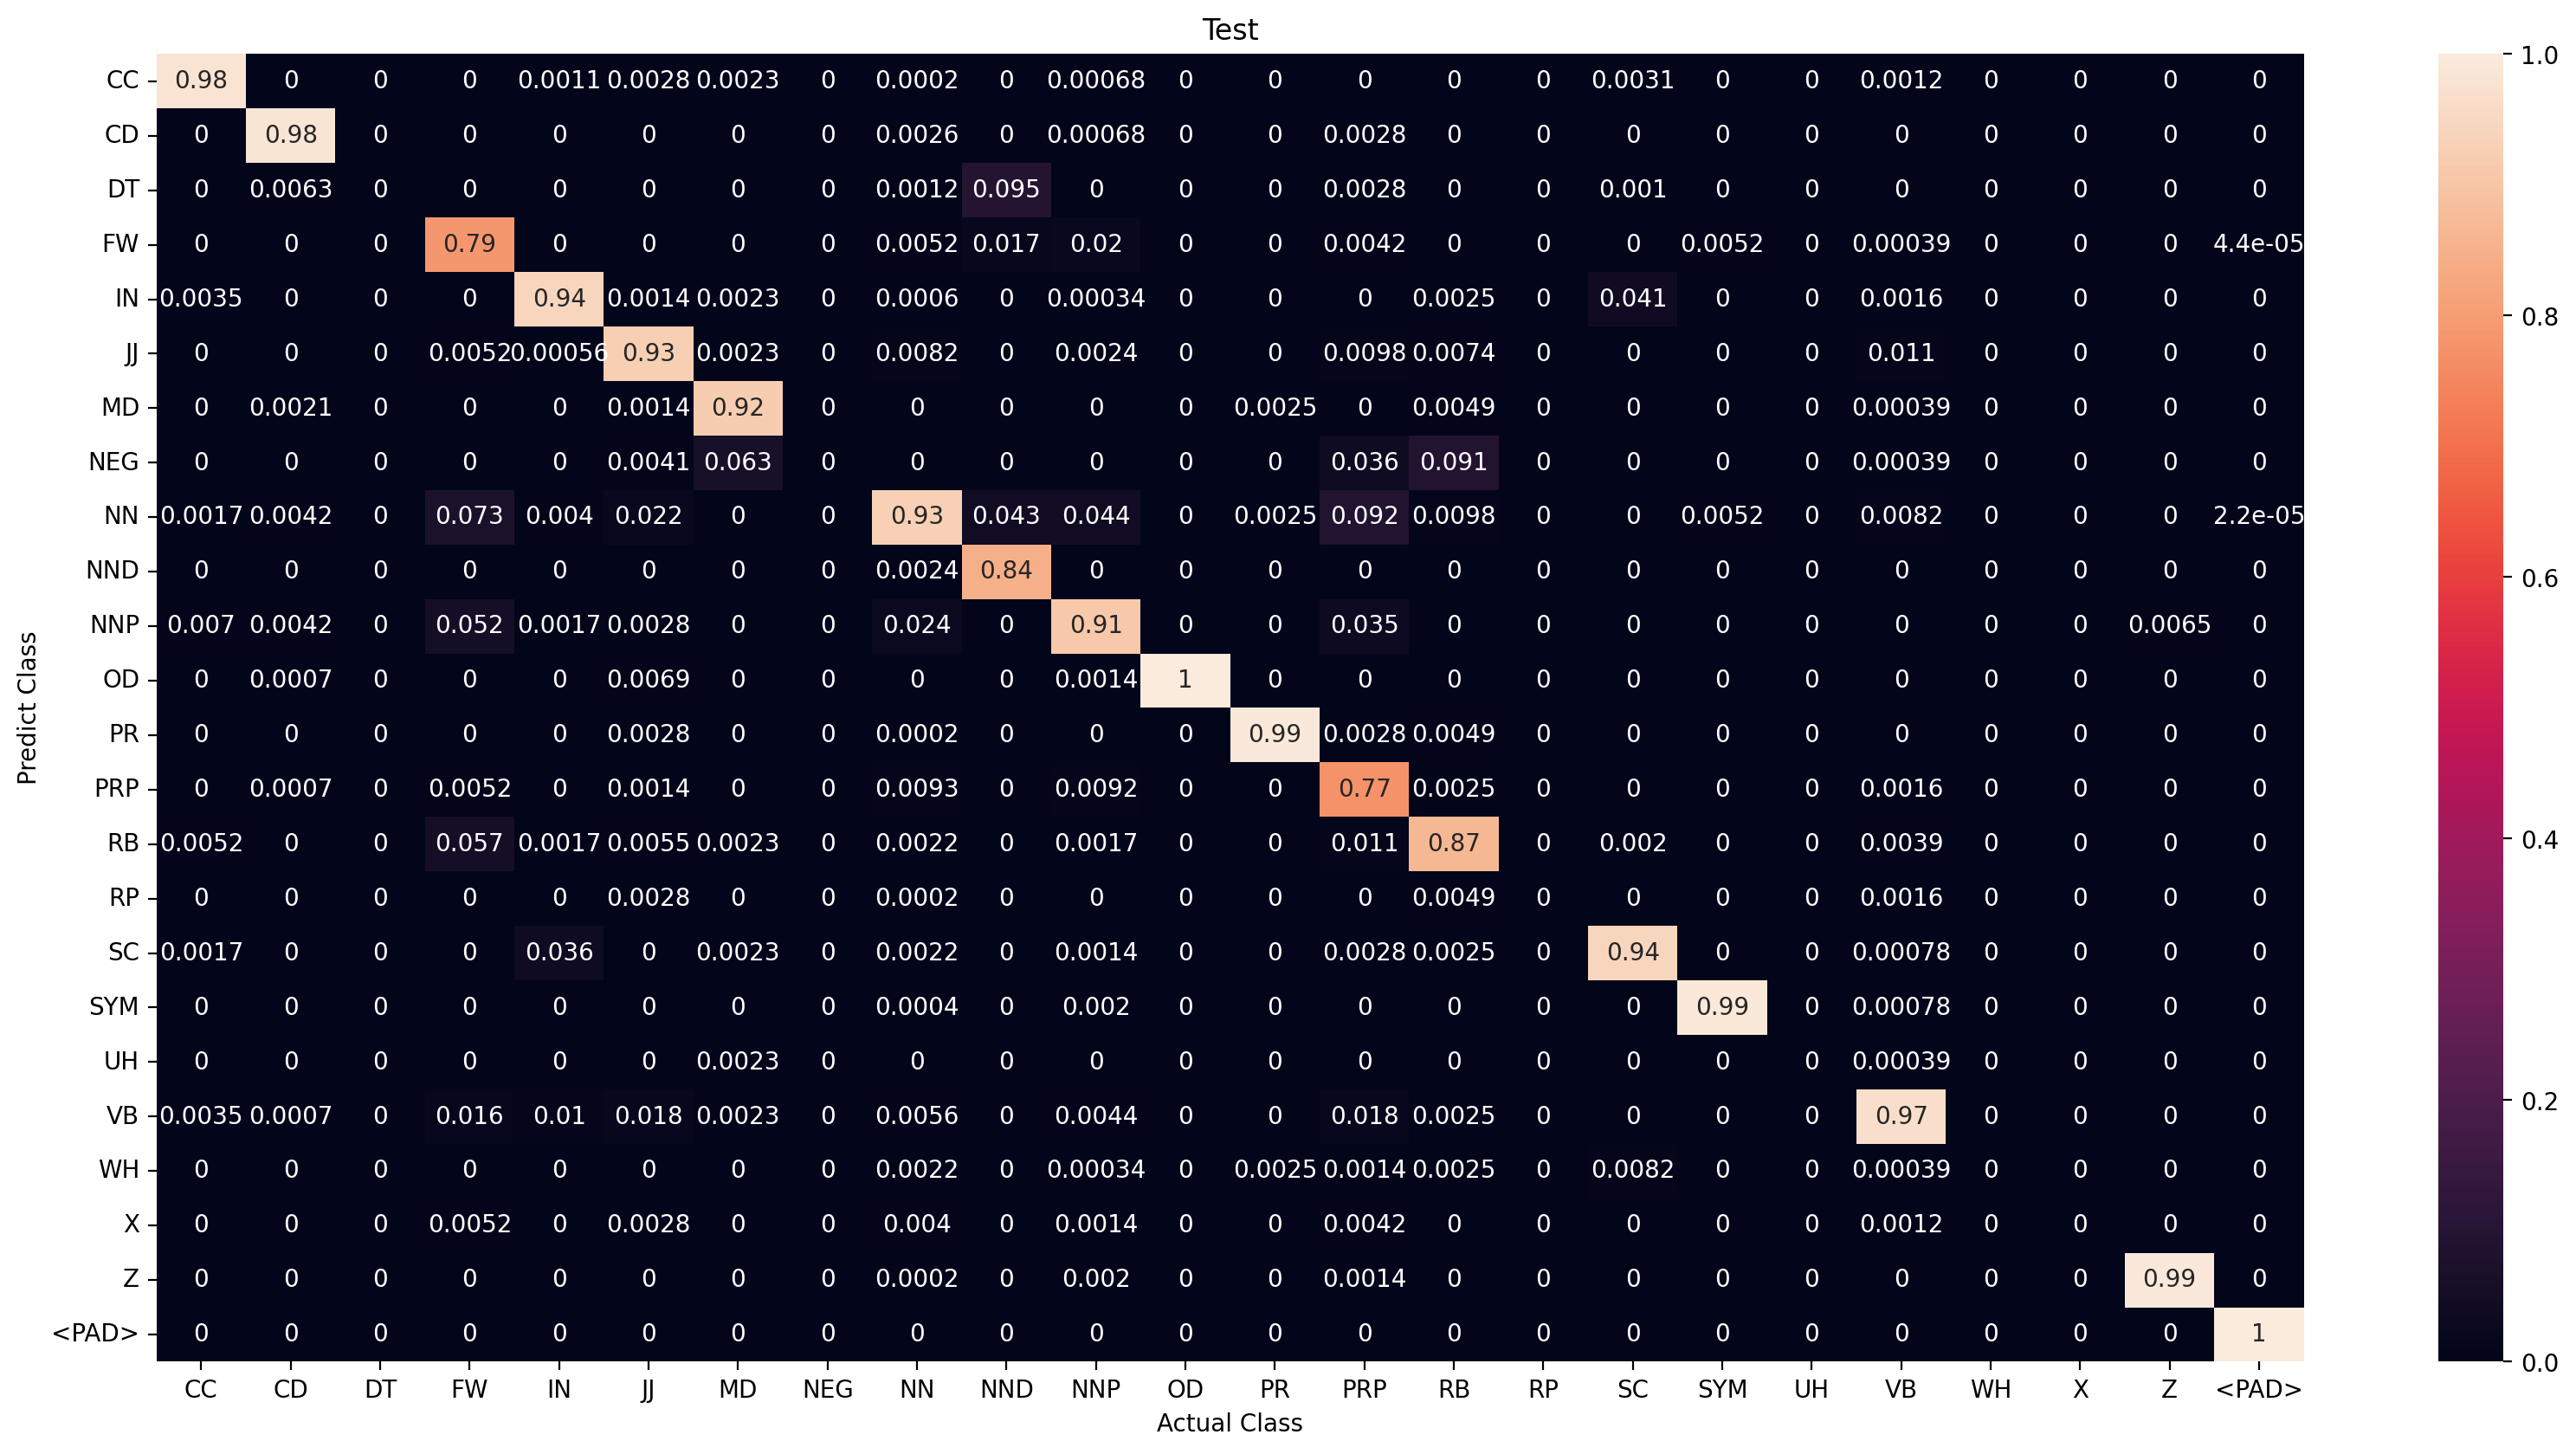

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5208       | CC    : 114      |
| CD    : 12758  | CD    : 12642      | CD    : 116      |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1366       | FW    : 300      |
| IN    : 15371  | IN    : 15237      | IN    : 134      |
| JJ    : 6997   | JJ    : 6561       | JJ    : 436      |
| MD    : 3774   | MD    : 3724       | MD    : 50       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44075      | NN    : 597      |
| NND   : 1021   | NND   : 924        | NND   : 97       |
| NNP   : 24845  | NNP   : 24153      | NNP   : 692      |
| OD    : 541    | OD    : 520        | OD    : 21       |
| PR    : 3896   | PR    : 3835       | PR    : 61       |
| PRP   : 5408   | PRP   : 5211       | PRP   : 197      |
| RB    : 3463   | RB    : 3211       | RB    : 252      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 10324
Wrong prediction            : 1497
Percentage correct oov pred : 87.33609677692242

Validation
Number OOV token            : 3350
Correct prediction          : 2369
Wrong prediction            : 981
Percentage correct oov pred : 70.71641791044776

Test
Number OOV token            : 1391
Correct prediction          : 970
Wrong prediction            : 421
Percentage correct oov pred : 69.73400431344356



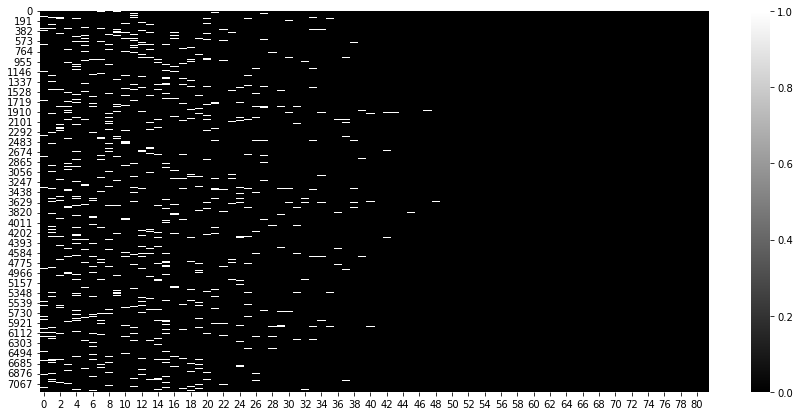

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

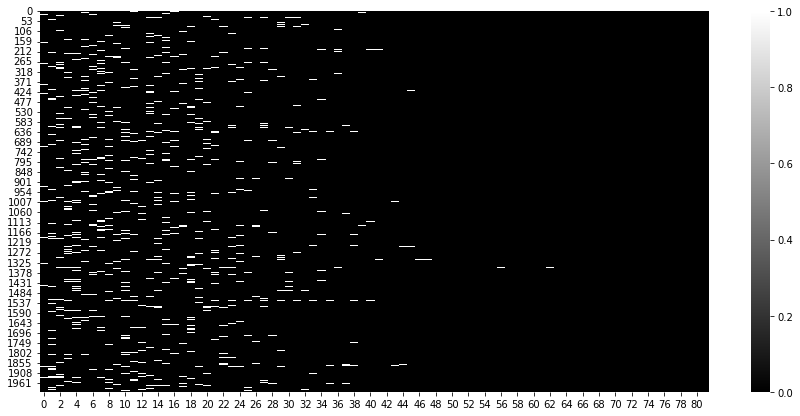

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

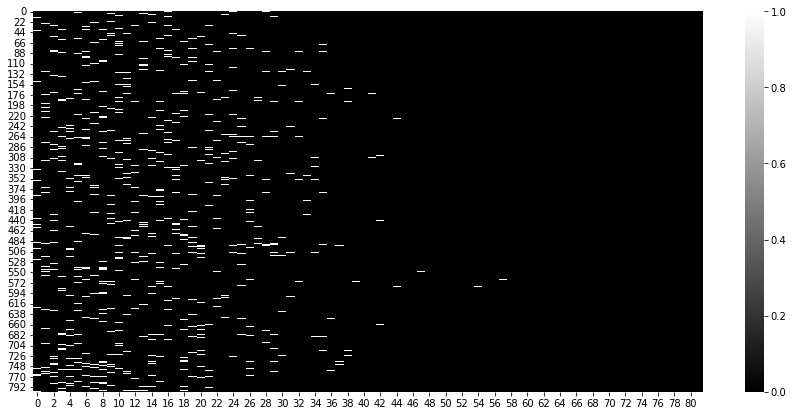

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);